In [ ]:
!pip install lenskit

In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 4.8 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630181 sha256=7f0b48055fc1ad887fd1fd85feeec861a0d4e2f697402aadffb59b7e3001965b
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
import surprise
import pandas as pd
data = surprise.Dataset.load_builtin('ml-100k')
ddir = surprise.get_dataset_dir()
r_cols = ['user', 'item', 'rating', 'timestamp']
ratings = pd.read_csv(f'{ddir}/ml-100k/ml-100k/u.data', sep='\t', names=r_cols,
                      encoding='latin-1')

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


In [ ]:
ratings.head()

,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
from lenskit.datasets import ML100K
from lenskit import batch, topn, util, topn
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn as knn
import pandas as pd
%matplotlib inline
#from lenskit import topn

In [ ]:
algo_ii = knn.ItemItem(20)
algo_als = als.BiasedMF(50)

In [ ]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    recs = batch.recommend(fittable, users, 100)
    recs['Algorithm'] = aname
    return recs

In [ ]:
all_recs = []
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('ItemItem', algo_ii, train, test))
    all_recs.append(eval('ALS', algo_als, train, test))

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
Numba is using threading layer omp - consider TBB
BLAS using multiple threads - can cause oversubscription
found 2 potential runtime problems - see https://boi.st/lkpy-perf
/usr/local/lib/python3.7/dist-packages/lenskit/algorithms/item_knn.py:119: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  b = blocks[bi]


In [ ]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs.head()

,item,score,user,rank,Algorithm
0,408,5.065250,1,1,ItemItem
1,851,5.007169,1,2,ItemItem
2,603,4.946283,1,3,ItemItem
3,1512,4.897497,1,4,ItemItem
4,963,4.894047,1,5,ItemItem


In [ ]:
test_data = pd.concat(test_data, ignore_index=True)

In [ ]:
test_data.head()

,user,item,rating
0,1,18,4
1,1,171,5
2,1,55,5
3,1,231,1
4,1,58,4


In [ ]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(all_recs, test_data)
results.head()

nrecs      ndcg
Algorithm user                 
ItemItem  1       100  0.227640
          5       100  0.200705
          7       100  0.248380
          10      100  0.226632
          11      100  0.009163

In [ ]:
results.groupby('Algorithm').ndcg.mean()

Algorithm
ALS         0.135808
ItemItem    0.101202
Name: ndcg, dtype: float64

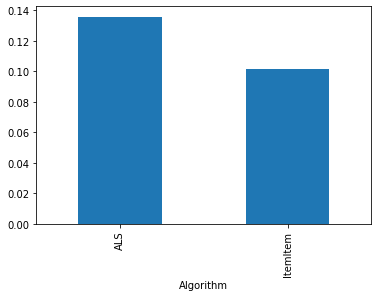

In [ ]:
results.groupby('Algorithm').ndcg.mean().plot.bar()